Image Classification - will fine-tune ViT on Human Action Recognition dataset

In [40]:
!pip install -q datasets transformers

In [41]:
from google.colab import output
output.enable_custom_widget_manager()

In [46]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [47]:
%%capture
%suda apt -qq install git-lfs
!git config --global credential.helper.store


In [48]:
!huggingface-cli login


        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
        
Token: 
Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your termin

#We'll import the datset directly from the HuggingFace hub

In [49]:
from datasets import load_dataset

data = load_dataset("rajistics/indian_food_images")


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/rajistics___parquet/rajistics--indian_food_images-cfe7c00f44dbf4fc/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [50]:
ex =  data["train"][100]

In [51]:
ex

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720 at 0x7F4CF014CB50>,
 'label': 1}

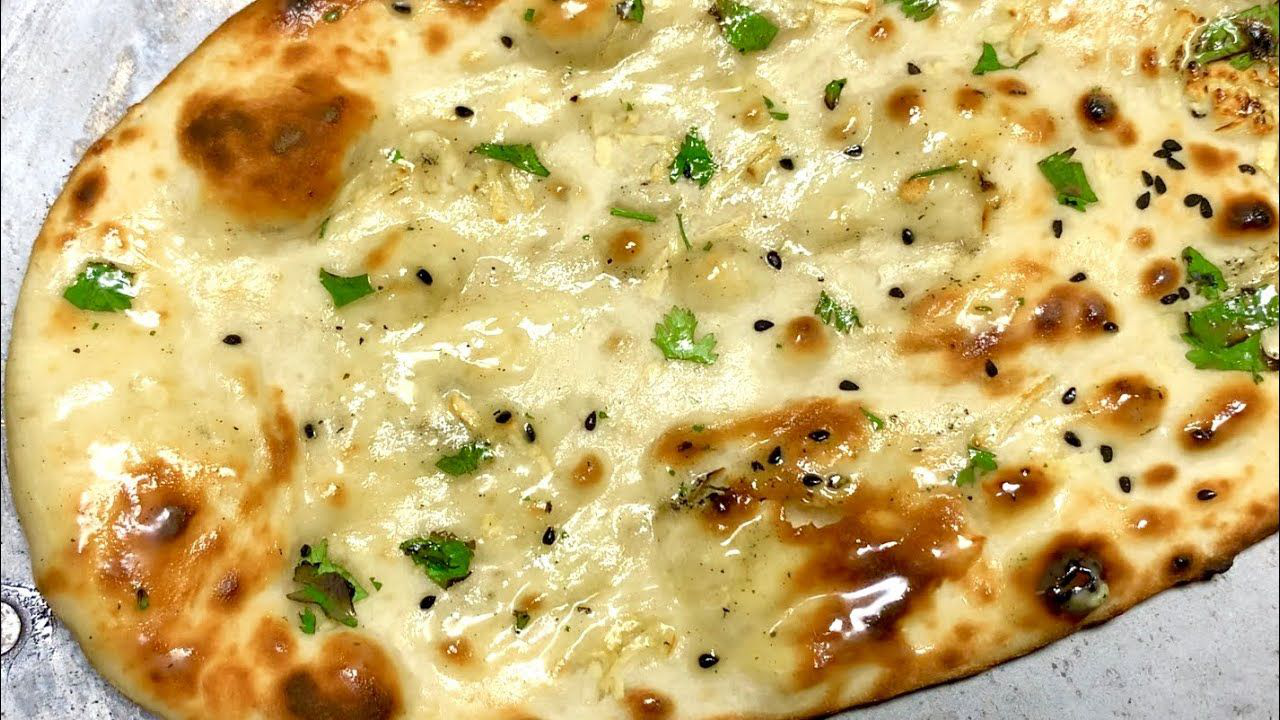

In [52]:
ex["image"]

In [54]:
ex["label"]

1

In [55]:
data["train"][100]["label"]

1

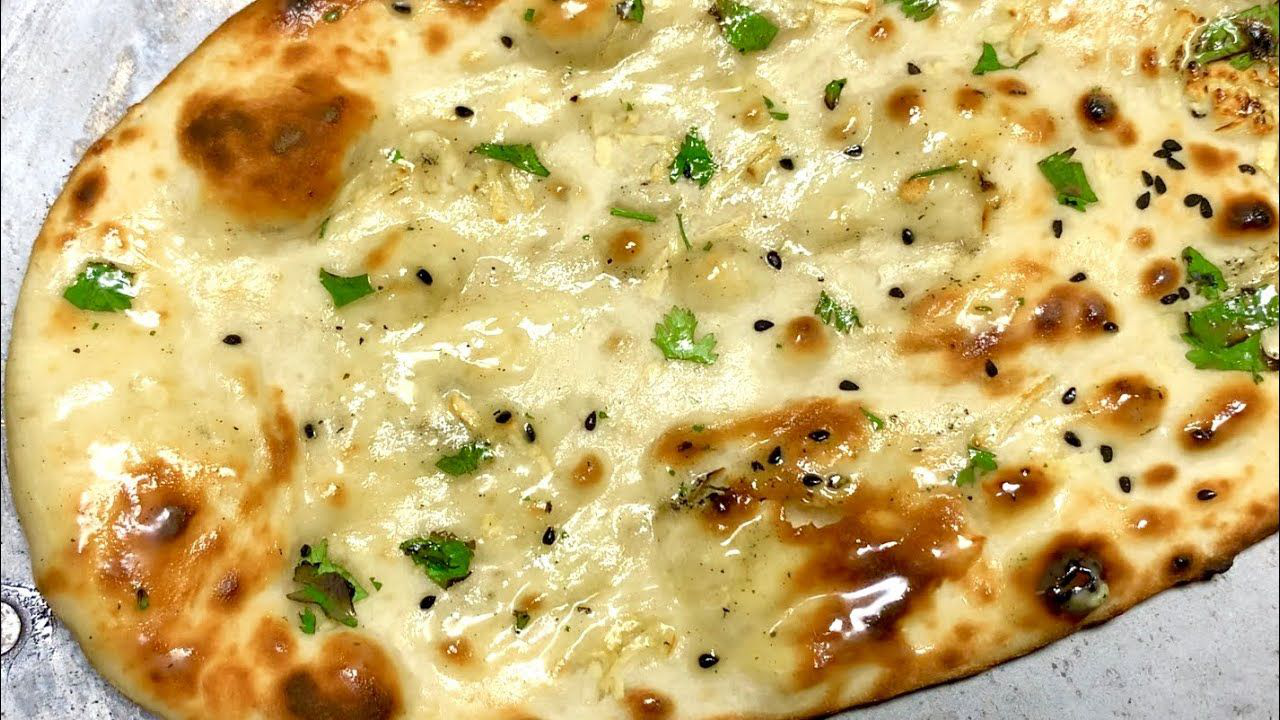

In [56]:
data["train"][100]["image"]

In [58]:
data["train"].features["label"]

ClassLabel(num_classes=20, names=['burger', 'butter_naan', 'chai', 'chapati', 'chole_bhature', 'dal_makhani', 'dhokla', 'fried_rice', 'idli', 'jalebi', 'kaathi_rolls', 'kadai_paneer', 'kulfi', 'masala_dosa', 'momos', 'paani_puri', 'pakode', 'pav_bhaji', 'pizza', 'samosa'], id=None)

In [60]:
data["train"].features["label"].names

['burger',
 'butter_naan',
 'chai',
 'chapati',
 'chole_bhature',
 'dal_makhani',
 'dhokla',
 'fried_rice',
 'idli',
 'jalebi',
 'kaathi_rolls',
 'kadai_paneer',
 'kulfi',
 'masala_dosa',
 'momos',
 'paani_puri',
 'pakode',
 'pav_bhaji',
 'pizza',
 'samosa']

In [61]:
data["train"].features["label"].names[7]

'fried_rice'

In [62]:
from datasets import load_metric
metric = load_metric("accuracy")



In [63]:
labels = data["train"].features["label"].names

label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
  label2id[label] = i 
  id2label[id] = label 

#Processing the data

In [64]:
from transformers import ViTFeatureExtractor

model_name_or_path = "google/vit-base-patch16-224-in21k"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

loading feature extractor configuration file https://huggingface.co/google/vit-base-patch16-224-in21k/resolve/main/preprocessor_config.json from cache at /root/.cache/huggingface/transformers/7c7f3e780b30eeeacd3962294e5154788caa6d9aa555ed6d5c2f0d2c485eba18.c322cbf30b69973d5aae6c0866f5cba198b5fe51a2fe259d2a506827ec6274bc
Feature extractor ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}



In [65]:
#Transformations


from torchvision.transforms import (
    CenterCrop,
    Compose, 
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor
)

In [66]:
normalize = Normalize(mean = feature_extractor.image_mean, std = feature_extractor.image_std )

In [67]:
train_transforms = Compose(
    [
        RandomResizedCrop(feature_extractor.size),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize
     ]
)

In [68]:
val_transforms = Compose(
    [
        Resize(feature_extractor.size),
        CenterCrop(feature_extractor.size),
        ToTensor(),
        normalize
    ]
)

In [69]:
def preprocess_train(example_batch):
  example_batch["pixel_values"] = [ train_transforms(image.convert("RGB")) for image in example_batch["image"]]
  return example_batch

In [70]:
def preprocess_val(example_batch):
  example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
  return example_batch

In [71]:
train_ds = data["train"]
val_ds = data["test"]     #since we don't have a validation set

In [72]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=480x360 at 0x7F4CF0141D90>,
 'label': 6}

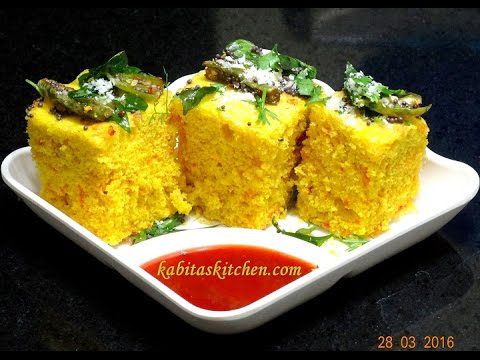

In [73]:
train_ds[0]["image"]

In [74]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [75]:
train_ds[0]    #so pizel values got added

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=480x360 at 0x7F4CF0124990>,
 'label': 6,
 'pixel_values': tensor([[[-0.6078, -0.6314, -0.6392,  ..., -0.9686, -0.9686, -0.9686],
          [-0.6157, -0.6314, -0.6314,  ..., -0.9686, -0.9686, -0.9686],
          [-0.6157, -0.6314, -0.6314,  ..., -0.9686, -0.9686, -0.9686],
          ...,
          [ 0.8431,  0.7412,  0.7490,  ...,  0.3804,  0.4353,  0.4039],
          [ 0.8275,  0.7490,  0.8039,  ...,  0.3882,  0.4196,  0.3961],
          [ 0.7725,  0.6941,  0.7804,  ...,  0.4510,  0.4667,  0.4510]],
 
         [[-0.6000, -0.6235, -0.6314,  ..., -0.9686, -0.9686, -0.9686],
          [-0.6078, -0.6235, -0.6235,  ..., -0.9686, -0.9686, -0.9686],
          [-0.6078, -0.6235, -0.6235,  ..., -0.9686, -0.9686, -0.9686],
          ...,
          [ 0.5137,  0.4039,  0.3961,  ...,  0.0980,  0.1529,  0.1216],
          [ 0.5059,  0.4275,  0.4667,  ...,  0.0980,  0.1294,  0.1137],
          [ 0.4510,  0.3725,  0.4510,  ...,  0.1529, 

In [76]:
val_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720 at 0x7F4CF0154E90>,
 'label': 16,
 'pixel_values': tensor([[[-0.6078, -0.7255, -0.7412,  ...,  0.6549,  0.6392,  0.6235],
          [-0.6706, -0.7725, -0.8196,  ...,  0.6941,  0.6549,  0.6078],
          [-0.7412, -0.8275, -0.8824,  ...,  0.7098,  0.6549,  0.6078],
          ...,
          [-0.1216, -0.0902,  0.0902,  ..., -0.6157, -0.9686, -0.9922],
          [-0.0980,  0.0118,  0.0902,  ..., -0.9059, -1.0000, -1.0000],
          [ 0.0118,  0.1373, -0.0431,  ..., -0.9843, -0.9843, -0.9843]],
 
         [[-0.8118, -0.8667, -0.8588,  ...,  0.7490,  0.7647,  0.7569],
          [-0.8353, -0.8745, -0.8902,  ...,  0.7961,  0.7804,  0.7490],
          [-0.8588, -0.8824, -0.9137,  ...,  0.8118,  0.7804,  0.7490],
          ...,
          [-0.5373, -0.4824, -0.2706,  ..., -0.7333, -0.9765, -0.9843],
          [-0.5451, -0.3804, -0.2549,  ..., -0.9529, -0.9843, -0.9843],
          [-0.4510, -0.2627, -0.3804,  ..., -0.9843

#Training the Model

In [77]:
from transformers import ViTForImageClassification
model_name_or_path = "google/vit-base-patch16-224-in21k"
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels = len(labels),
    id2label = {str(i):c for i, c in enumerate(labels)},
    label2id = {c:str(i) for i,c in enumerate(labels)}
)


loading configuration file https://huggingface.co/google/vit-base-patch16-224-in21k/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/7bba26dd36a6ff9f6a9b19436dec361727bea03ec70fbfa82b70628109163eaa.92995a56e2eabab0c686015c4ad8275b4f9cbd858ed228f6a08936f2c31667e7
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "burger",
    "1": "butter_naan",
    "10": "kaathi_rolls",
    "11": "kadai_paneer",
    "12": "kulfi",
    "13": "masala_dosa",
    "14": "momos",
    "15": "paani_puri",
    "16": "pakode",
    "17": "pav_bhaji",
    "18": "pizza",
    "19": "samosa",
    "2": "chai",
    "3": "chapati",
    "4": "chole_bhature",
    "5": "dal_makhani",
    "6": "dhokla",
    "7": "fried_rice",
    "8": "idli",
    "9": "jalebi"
  },

In [78]:
#Setting up the training Arguments



from transformers import TrainingArguments

training_args = TrainingArguments(
    "DrishtiSharma/finetuned-ViT-Indian-Food-Classification-v1",
    per_device_train_batch_size = 16,
    evaluation_strategy = "steps",
    num_train_epochs = 5,
    fp16 = True,
    save_steps =100,
    eval_steps = 100,
    logging_steps =10,
    learning_rate = 2e-4,
    save_total_limit = 2,
    remove_unused_columns = False,
    push_to_hub = True,
    report_to = "tensorboard",
    load_best_model_at_end = True,
    hub_strategy = "end"
)

PyTorch: setting up devices


In [79]:
# Defining a fucntion for Computing accuracy on a batch of predictions

import numpy as np

def compute_metrics(eval_pred):
  predictions = np.argmax(eval_pred.predictions, axis=1)
  return metric.compute(predictions = predictions, references = eval_pred.label_ids)


In [83]:
import torch

def collate_fn(batch):
  """batches examples together"""
  return {
      "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
      "labels": torch.tensor([x["label"] for x in batch])
  }

In [84]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset = train_ds,
    eval_dataset = val_ds,
    tokenizer = feature_extractor,
    compute_metrics = compute_metrics,
    data_collator = collate_fn

)

/content/DrishtiSharma/finetuned-ViT-Indian-Food-Classification-v1 is already a clone of https://huggingface.co/DrishtiSharma/finetuned-ViT-Indian-Food-Classification-v1. Make sure you pull the latest changes with `repo.git_pull()`.
Using cuda_amp half precision backend


In [85]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5328
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1665


***** Running Evaluation *****
  Num examples = 941
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
Saving model checkpoint to DrishtiSharma/finetuned-ViT-Indian-Food-Classification-v1/checkpoint-100
Configuration saved in DrishtiSharma/finetuned-ViT-Indian-Food-Classification-v1/checkpoint-100/config.json
Model weights saved in DrishtiSharma/finetuned-ViT-Indian-Food-Classification-v1/checkpoint-100/pytorch_model.bin
Feature extractor saved in DrishtiSharma/finetuned-ViT-Indian-Food-Classification-v1/checkpoint-100/preprocessor_config.json
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))
***** Running Evaluation *****
  Num examples = 941
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarn

Upload file pytorch_model.bin:   0%|          | 3.34k/327M [00:00<?, ?B/s]

Upload file runs/Sep01_13-52-09_1406f9715ee7/events.out.tfevents.1662040364.1406f9715ee7.67.5:   9%|9         …

Upload file training_args.bin: 100%|##########| 3.30k/3.30k [00:00<?, ?B/s]

Upload file runs/Sep01_13-52-09_1406f9715ee7/1662040336.2742372/events.out.tfevents.1662040336.1406f9715ee7.67…

Upload file runs/Sep01_13-52-09_1406f9715ee7/1662040364.6786563/events.out.tfevents.1662040364.1406f9715ee7.67…

Upload file runs/Sep01_13-52-09_1406f9715ee7/events.out.tfevents.1662040336.1406f9715ee7.67.3:  75%|#######5  …

To https://huggingface.co/DrishtiSharma/finetuned-ViT-Indian-Food-Classification-v1
   c834e6e..e198fa6  main -> main

   c834e6e..e198fa6  main -> main

To https://huggingface.co/DrishtiSharma/finetuned-ViT-Indian-Food-Classification-v1
   e198fa6..64e7c16  main -> main

   e198fa6..64e7c16  main -> main



***** train metrics *****
  epoch                    =          5.0
  total_flos               = 1922920017GF
  train_loss               =       0.4258
  train_runtime            =   0:31:12.05
  train_samples_per_second =        14.23
  train_steps_per_second   =        0.889


#Evaluate the model

In [86]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 941
  Batch size = 8


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =     0.9341
  eval_loss               =     0.2665
  eval_runtime            = 0:00:37.78
  eval_samples_per_second =     24.903
  eval_steps_per_second   =      3.123


In [87]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": "Human_Action_Recognition",
    "tags": ["image-classification"],
}

In [88]:
from google.colab import output
output.enable_custom_widget_manager()

In [89]:
if training_args.push_to_hub:
  trainer.push_to_hub("YAY!!",  **kwargs)
else:
  trainer.create_model_card(**kwargs)

Saving model checkpoint to DrishtiSharma/finetuned-ViT-Indian-Food-Classification-v1
Configuration saved in DrishtiSharma/finetuned-ViT-Indian-Food-Classification-v1/config.json
Model weights saved in DrishtiSharma/finetuned-ViT-Indian-Food-Classification-v1/pytorch_model.bin
Feature extractor saved in DrishtiSharma/finetuned-ViT-Indian-Food-Classification-v1/preprocessor_config.json


Upload file runs/Sep01_13-52-09_1406f9715ee7/events.out.tfevents.1662042562.1406f9715ee7.67.7: 100%|##########…

To https://huggingface.co/DrishtiSharma/finetuned-ViT-Indian-Food-Classification-v1
   64e7c16..d7b0ec9  main -> main

   64e7c16..d7b0ec9  main -> main

To https://huggingface.co/DrishtiSharma/finetuned-ViT-Indian-Food-Classification-v1
   d7b0ec9..205fcae  main -> main

   d7b0ec9..205fcae  main -> main



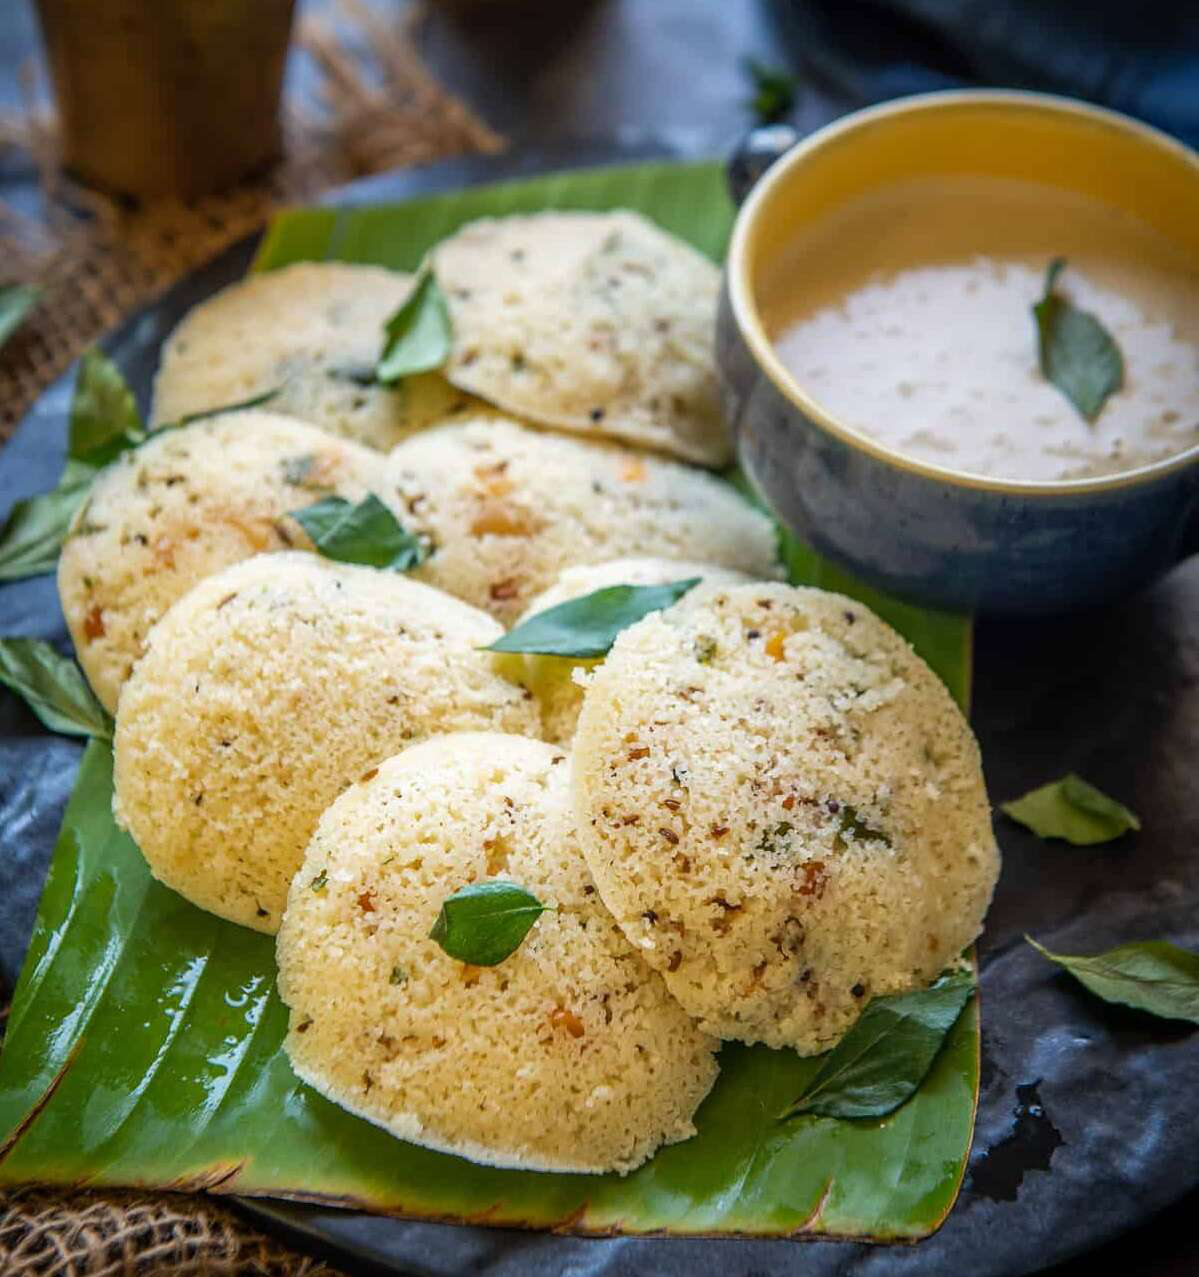

In [92]:
#Inference:

from PIL import Image
import requests

url = "https://imagesvc.meredithcorp.io/v3/mm/image?url=https%3A%2F%2Fimages.media-allrecipes.com%2Fuserphotos%2F8195764.jpg&q=60"
image = Image.open(requests.get(url, stream=True).raw)
image

In [91]:
from transformers import AutoModelForImageClassification, AutoFeatureExtractor
repo_name = "DrishtiSharma/finetuned-ViT-Indian-Food-Classification-v1"


feature_extractor = AutoFeatureExtractor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

loading feature extractor configuration file DrishtiSharma/finetuned-ViT-Indian-Food-Classification-v1/preprocessor_config.json
Feature extractor ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

loading configuration file DrishtiSharma/finetuned-ViT-Indian-Food-Classification-v1/config.json
Model config ViTConfig {
  "_name_or_path": "DrishtiSharma/finetuned-ViT-Indian-Food-Classification-v1",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "burger",
    "1": "butter_naan",
    "2": "chai",
    "3": "chapati",
    "4": "chole_bhature",
    "5": "dal_makhani",
    "6": "dhokla",
    "7": "fried_rice",
    "8": "idli",
 

In [93]:
#prepare image for the model

encoding = feature_extractor(image.convert("RGB"), return_tensors = "pt")
print(encoding.pixel_values.shape)



torch.Size([1, 3, 224, 224])


In [94]:
import torch

#forward pass

with torch.no_grad():
  outputs = model(**encoding)
  logits = outputs.logits

In [95]:
predicted_class_idx = logits.argmax(-1).item()

In [96]:
print("predicted_class:", model.config.id2label[predicted_class_idx])

predicted_class: idli


#Pipeline API

In [ ]:
from transformers import pipeline
pipe = pipeline("image-classification", "DrishtiSharma/finetuned-ViT-human-action-recognition")


In [ ]:
pipe(image)